<a href="https://colab.research.google.com/github/MADHAVAHARSHA/Analysis_of_Alzheimer-s_MRI_Dataset/blob/main/Analysis_of_Alzheimer's_MRI_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract Data

# Task: Analysis of Alzheimer's MRI Dataset Objective: To develop and compare multiple machine learning models, including a
* transfer learning model,
* a custom-built deep neural network (DNN)
* a model designed by the students

In [ ]:
! unrar x "Alzheimer_s Dataset.rar"

Streaming output truncated to the last 5000 lines.
Extracting  Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg         20%  OK 
Extracting  Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg         20%  OK 
Extracting  Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg         20%  OK 
Extracting  Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg         20%  OK 
Extracting  Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg         20%  OK 
Extracting  Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg         20%  OK 
Extracting  Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg         20%  OK 
Extracting  Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg         20%  OK 
Extracting  Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg         20%  OK 
Extracting  Alzheimer_s Dataset/train/MildDemented/mildDem219.jpg         20%  OK 
Extracting  Alzheimer_s Datas

We need to accurately classify the stage of Alzheimer's disease from MRI images.
 Dataset Overview: • Title: Alzheimer's Dataset (4 class of Images) • Image Types:
 * Mild Demented
 * Moderate Demented
 * Non Demented
 * Very Mild Demented

* 1. Exploratory Data Analysis (EDA): • Download the dataset from the files section. • Visualize different classes of images to identify distinguishing features.

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

# Loading Train and test data from extracted Alzheimer zip file
train_path = 'Alzheimer_s Dataset/train'
test_path = 'Alzheimer_s Dataset/test'

# Function to load images from a given directory
def load_images(directory):
    images = {}
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        class_images = []
        for img in os.listdir(class_path):
            img_path = os.path.join(class_path, img)
            class_images.append(img_path)
        images[class_folder] = class_images
    return images

# Load train and test images
train_images = load_images(train_path)
test_images = load_images(test_path)


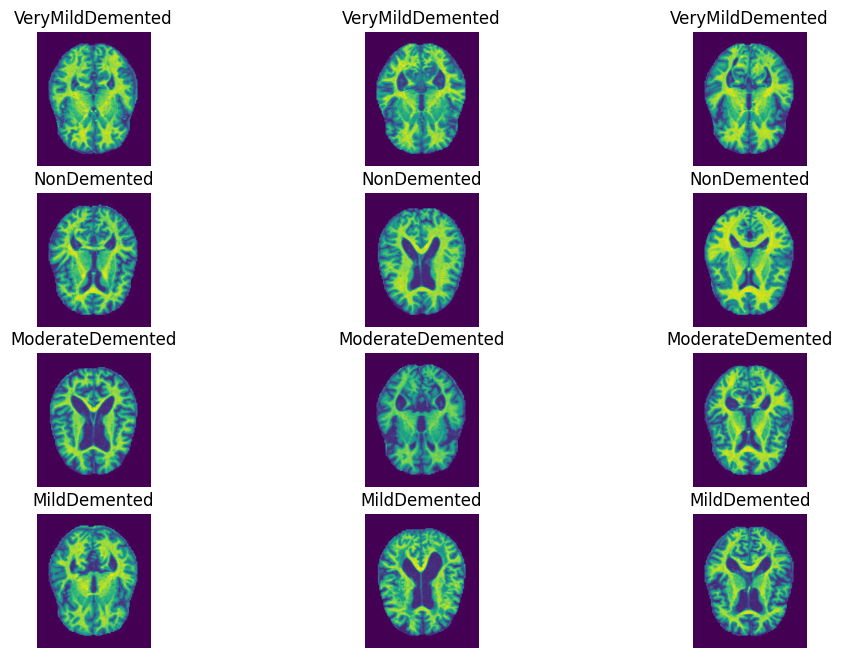

In [ ]:
# Function to visualize random images from each class
def visualize_random_images(images_dict, num_images_per_class=3):
    plt.figure(figsize=(12, 8))

    for class_folder, class_images in images_dict.items():
        random_images = random.sample(class_images, num_images_per_class)

        for i, img_path in enumerate(random_images, 1):
            plt.subplot(len(images_dict), num_images_per_class, (list(images_dict.keys()).index(class_folder) * num_images_per_class) + i)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f'{class_folder}')
            plt.axis('off')

    plt.show()

# Visualize random images from the training set
visualize_random_images(train_images)



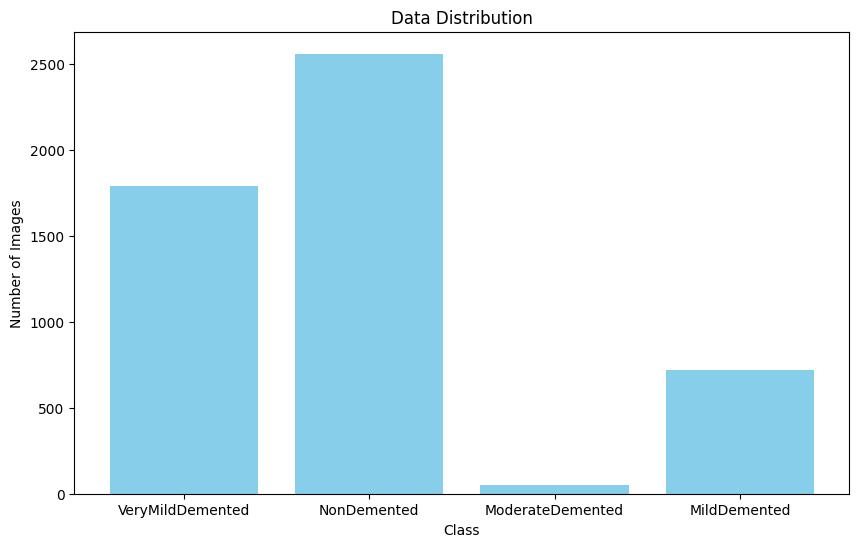

In [ ]:
# Function to plot the distribution of data
def plot_data_distribution(images_dict):
    class_labels = list(images_dict.keys())
    num_images = [len(class_images) for class_images in images_dict.values()]

    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, num_images, color='skyblue')
    plt.title('Data Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

# Plot the distribution of the training data
plot_data_distribution(train_images)


* By seeing the above data visually we can say that the dataset itself is inbalanced so we need to balance that data by doing some augmentation or by using Compute_class_weight

2. Data Preprocessing: • Apply image preprocessing techniques such as resizing, normalization, and augmentation to prepare the dataset for modeling.

* Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalization
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)  # only normalization for test set

# Applying the transformations to the dataset
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(208, 176),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(208, 176),
    batch_size=32,
    class_mode='categorical')


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


* caluculating the class weight of the labels

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def compute_class_weights(classes, counts):
    class_indices = list(range(len(classes)))
    y = np.concatenate([[i] * count for i, count in zip(class_indices, counts)])

    weights = compute_class_weight('balanced', classes=class_indices, y=y)

    class_weights = {i: weight for i, weight in zip(class_indices, weights)}
    return class_weights

# Example usage
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
counts = np.array([717, 52, 2560, 1792])

computed_weights = compute_class_weights(classes, counts)
print(computed_weights)


{0: 1.7855648535564854, 1: 24.620192307692307, 2: 0.50009765625, 3: 0.7144252232142857}


 3. Model Selection and Training: • Implement three different models for the classification task: • Transfer Learning Model: Utilize a pre-trained model and fine-tune it for the Alzheimer's MRI image dataset. • Custom Deep Neural Network (DNN): Construct and train a DNN from scratch specifically tailored for this dataset. • Student-Designed Model: Design and train an original model. justifying the architecture and parameter

## VGG16

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_and_train_vgg16(train_generator, test_generator, class_weights=None, epochs=10):
    # Load pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(208, 176, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Adding custom layers
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax')(x)

    vgg16_model = Model(inputs=base_model.input, outputs=x)

    # Compile the model
    vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model and return the history
    history = vgg16_model.fit(train_generator, validation_data=test_generator, epochs=epochs, class_weight=class_weights)

    # Evaluate the model on the test set
    test_loss, test_accuracy = vgg16_model.evaluate(test_generator)
    print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

    return history

history = build_and_train_vgg16(train_generator, test_generator, epochs=10)



58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/10
161/161 [==============================] - 80s 413ms/step - loss: 1.1236 - accuracy: 0.4901 - val_loss: 1.0688 - val_accuracy: 0.5035
Epoch 2/10
161/161 [==============================] - 59s 368ms/step - loss: 0.9813 - accuracy: 0.5216 - val_loss: 1.0023 - val_accuracy: 0.5215
Epoch 3/10
161/161 [==============================] - 61s 377ms/step - loss: 0.9534 - accuracy: 0.5436 - val_loss: 0.9708 - val_accuracy: 0.5309
Epoch 4/10
161/161 [==============================] - 60s 375ms/step - loss: 0.9199 - accuracy: 0.5636 - val_loss: 0.9873 - val_accuracy: 0.5278
Epoch 5/10
161/161 [==============================] - 61s 376ms/step - loss: 0.9193 - accuracy: 0.5532 - val_loss: 1.0218 - val_accuracy: 0.5317
Epoch 6/10
161/161 [==============================] - 61s 379ms/step - loss: 0.9053 - accuracy: 0.5694 - val_loss: 0.9745 - val_accuracy: 0.5489
Epoch 7/10
161/161 [==============================] - 63s 391ms/s

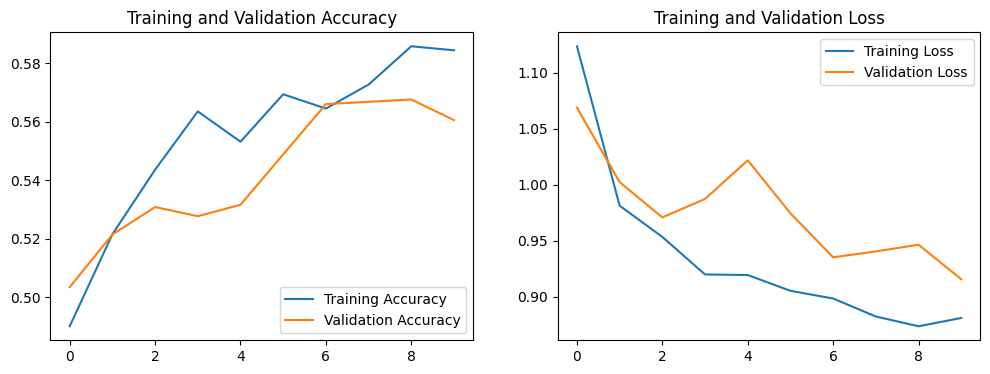

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
# Plot training history
plot_training_history(history)

# Deep Learning Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def custom_model(input_shape=(208, 176, 3), num_classes=4):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Example usage
custom_model = custom_model()
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 206, 174, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 103, 87, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 101, 85, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 42, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 40, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 20, 128)       0

Epoch 1/10
161/161 [==============================] - 57s 323ms/step - loss: 1.0517 - accuracy: 0.4874 - val_loss: 1.0493 - val_accuracy: 0.5004
Epoch 2/10
161/161 [==============================] - 52s 324ms/step - loss: 0.9973 - accuracy: 0.5227 - val_loss: 0.9567 - val_accuracy: 0.5434
Epoch 3/10
161/161 [==============================] - 53s 331ms/step - loss: 0.9709 - accuracy: 0.5306 - val_loss: 0.9284 - val_accuracy: 0.5668
Epoch 4/10
161/161 [==============================] - 53s 327ms/step - loss: 0.9435 - accuracy: 0.5409 - val_loss: 0.9103 - val_accuracy: 0.5653
Epoch 5/10
161/161 [==============================] - 57s 350ms/step - loss: 0.9374 - accuracy: 0.5561 - val_loss: 0.9157 - val_accuracy: 0.5653
Epoch 6/10
161/161 [==============================] - 55s 337ms/step - loss: 0.9253 - accuracy: 0.5458 - val_loss: 0.9889 - val_accuracy: 0.5215
Epoch 7/10
161/161 [==============================] - 54s 336ms/step - loss: 0.9160 - accuracy: 0.5559 - val_loss: 0.9095 - val_ac

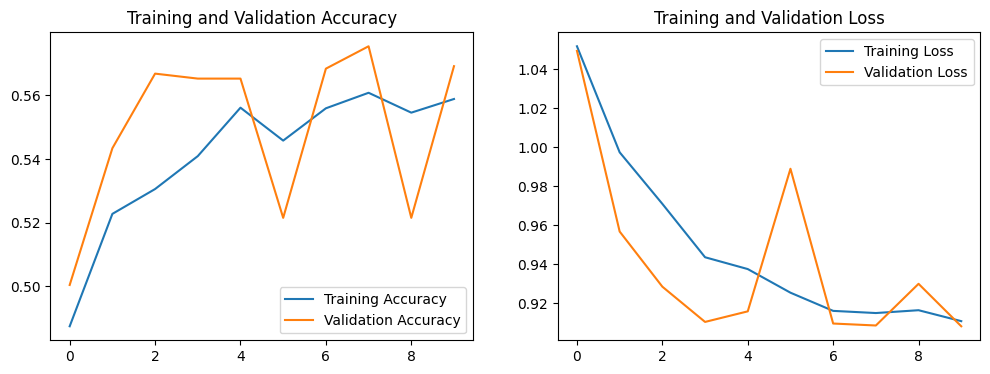

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam


# Compile the model
custom_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history = custom_model.fit(train_generator,
                           validation_data=test_generator,
                           epochs=10)

# Evaluate the model
test_loss, test_accuracy = custom_model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


# Custom model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def custom_model_v2(input_shape=(208, 176, 3), num_classes=4, filters=(32, 64, 128, 256), dense_units=(512, 256), dropout_rates=(0.5, 0.3)):
    model = Sequential()

    # Convolutional layers
    for filter_size in filters:
        model.add(Conv2D(filter_size, (3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(dropout_rates[0]))

    # Flatten and fully connected layers
    model.add(Flatten())

    for units in dense_units:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rates[1]))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Example usage
custom_model2 = custom_model_v2(input_shape=(208, 176, 3), num_classes=4, filters=(32, 64, 128, 256), dense_units=(512, 256), dropout_rates=(0.5, 0.3))
custom_model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 206, 174, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 103, 87, 32)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 103, 87, 32)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 101, 85, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 50, 42, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 50, 42, 64)       

Epoch 1/10
161/161 [==============================] - 58s 337ms/step - loss: 1.1010 - accuracy: 0.4673 - val_loss: 1.3247 - val_accuracy: 0.5004
Epoch 2/10
161/161 [==============================] - 56s 345ms/step - loss: 1.0603 - accuracy: 0.4776 - val_loss: 1.3192 - val_accuracy: 0.5246
Epoch 3/10
161/161 [==============================] - 56s 347ms/step - loss: 1.0545 - accuracy: 0.4888 - val_loss: 1.3218 - val_accuracy: 0.4738
Epoch 4/10
161/161 [==============================] - 58s 361ms/step - loss: 1.0445 - accuracy: 0.4907 - val_loss: 1.3168 - val_accuracy: 0.5090
Epoch 5/10
161/161 [==============================] - 56s 345ms/step - loss: 1.0444 - accuracy: 0.4960 - val_loss: 1.3149 - val_accuracy: 0.3503
Epoch 6/10
161/161 [==============================] - 55s 339ms/step - loss: 1.0439 - accuracy: 0.4872 - val_loss: 1.3159 - val_accuracy: 0.4019
Epoch 7/10
161/161 [==============================] - 56s 348ms/step - loss: 1.0372 - accuracy: 0.4976 - val_loss: 1.3260 - val_ac

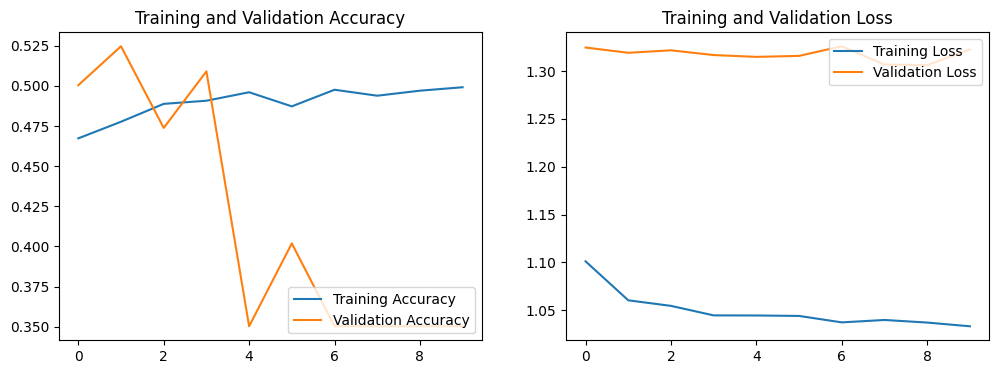

In [ ]:
# Compile the model
custom_model2.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history = custom_model2.fit(train_generator,
                           validation_data=test_generator,
                           epochs=10)

# Evaluate the model
test_loss, test_accuracy = custom_model2.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
vgg16_test_loss, vgg16_test_accuracy = history.model.evaluate(test_generator)
vgg16_predictions = history.model.predict(test_generator)
vgg16_pred_classes = np.argmax(vgg16_predictions, axis=1)
vgg16_true_classes = test_generator.classes

# Evaluate Custom Model
custom_test_loss, custom_test_accuracy = custom_model.evaluate(test_generator)
custom_predictions = custom_model.predict(test_generator)
custom_pred_classes = np.argmax(custom_predictions, axis=1)
custom_true_classes = test_generator.classes

# Evaluate Custom Model V2
custom_v2_test_loss, custom_v2_test_accuracy = custom_model2.evaluate(test_generator)
custom_v2_predictions = custom_model2.predict(test_generator)
custom_v2_pred_classes = np.argmax(custom_v2_predictions, axis=1)
custom_v2_true_classes = test_generator.classes

# Print and compare classification reports
print("VGG16 Model:")
print(classification_report(vgg16_true_classes, vgg16_pred_classes))

print("Custom Model:")
print(classification_report(custom_true_classes, custom_pred_classes))

print("Custom Model V2:")
print(classification_report(custom_v2_true_classes, custom_v2_pred_classes))



40/40 [==============================] - 2s 55ms/step
VGG16 Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00       640
           3       0.35      1.00      0.52       448

    accuracy                           0.35      1279
   macro avg       0.09      0.25      0.13      1279
weighted avg       0.12      0.35      0.18      1279

Custom Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.00      0.00      0.00        12
           2       0.50      0.60      0.55       640
           3       0.36      0.42      0.39       448

    accuracy                           0.45      1279
   macro avg       0.22      0.25      0.23      1279
weighted avg       0.38      0.45      0.41      1279

Custom Model V2:
              precision    recal

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

It looks like there might be an issue with the class distribution or the training process, especially for classes 0, 1, and 2 in both the VGG16 model and Custom Model V2. These models are struggling to predict those classes, and precision, recall, and F1-score are very low.

# with class weights on VGG16

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_and_train_vgg16(train_generator, test_generator, class_weights=None, epochs=10):
    # Load pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(208, 176, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Adding custom layers
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax')(x)

    vgg16_model = Model(inputs=base_model.input, outputs=x)

    # Compile the model
    vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model and return the history
    history = vgg16_model.fit(train_generator, validation_data=test_generator, epochs=epochs, class_weight=class_weights)

    # Evaluate the model on the test set
    test_loss, test_accuracy = vgg16_model.evaluate(test_generator)
    print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

    return history

history = build_and_train_vgg16(train_generator, test_generator,class_weights = computed_weights, epochs=5)



Epoch 1/5
161/161 [==============================] - 64s 391ms/step - loss: 1.8210 - accuracy: 0.3107 - val_loss: 0.9762 - val_accuracy: 0.5176
Epoch 2/5
161/161 [==============================] - 79s 491ms/step - loss: 1.5835 - accuracy: 0.3368 - val_loss: 1.0540 - val_accuracy: 0.5090
Epoch 3/5
161/161 [==============================] - 82s 511ms/step - loss: 1.3317 - accuracy: 0.3851 - val_loss: 1.1607 - val_accuracy: 0.4597
Epoch 4/5
161/161 [==============================] - 63s 390ms/step - loss: 1.3008 - accuracy: 0.3837 - val_loss: 1.0661 - val_accuracy: 0.5504
Epoch 5/5
40/40 [==============================] - 4s 102ms/step - loss: 1.0283 - accuracy: 0.5481
Test accuracy: 0.5480844378471375, Test loss: 1.0282821655273438


# Deep learning model with weights

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def custom_model(input_shape=(208, 176, 3), num_classes=4):
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Example usage
custom_model = custom_model()
custom_model.summary()

# Compile the model
custom_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model with class_weights
history = custom_model.fit(train_generator,
                           validation_data=test_generator,
                           epochs=5,
                           class_weight=computed_weights)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 206, 174, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 103, 87, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 101, 85, 64)       18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 50, 42, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 40, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 24, 20, 128)      

# custom model with weights

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def custom_model_v2(input_shape=(208, 176, 3), num_classes=4, filters=(32, 64, 128, 256), dense_units=(512, 256), dropout_rates=(0.5, 0.3)):
    model = Sequential()

    # Convolutional layers
    for filter_size in filters:
        model.add(Conv2D(filter_size, (3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(dropout_rates[0]))

    # Flatten and fully connected layers
    model.add(Flatten())

    for units in dense_units:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rates[1]))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Example usage
custom_model2 = custom_model_v2(input_shape=(208, 176, 3), num_classes=4, filters=(32, 64, 128, 256), dense_units=(512, 256), dropout_rates=(0.5, 0.3))
custom_model2.summary()

# Compile the model
custom_model2.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model with class_weight
history = custom_model2.fit(train_generator,
                            validation_data=test_generator,
                            epochs=5,
                            class_weight=computed_weights)

# Evaluate the model
test_loss, test_accuracy = custom_model2.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 206, 174, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 103, 87, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 103, 87, 32)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 101, 85, 64)       18496     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 50, 42, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 50, 42, 64)       

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
vgg16_test_loss, vgg16_test_accuracy = history.model.evaluate(test_generator)
vgg16_predictions = history.model.predict(test_generator)
vgg16_pred_classes = np.argmax(vgg16_predictions, axis=1)
vgg16_true_classes = test_generator.classes

# Evaluate Custom Model
custom_test_loss, custom_test_accuracy = custom_model.evaluate(test_generator)
custom_predictions = custom_model.predict(test_generator)
custom_pred_classes = np.argmax(custom_predictions, axis=1)
custom_true_classes = test_generator.classes

# Evaluate Custom Model V2
custom_v2_test_loss, custom_v2_test_accuracy = custom_model2.evaluate(test_generator)
custom_v2_predictions = custom_model2.predict(test_generator)
custom_v2_pred_classes = np.argmax(custom_v2_predictions, axis=1)
custom_v2_true_classes = test_generator.classes

# Print and compare classification reports
print("VGG16 Model:")
print(classification_report(vgg16_true_classes, vgg16_pred_classes))

print("Custom Model:")
print(classification_report(custom_true_classes, custom_pred_classes))

print("Custom Model V2:")
print(classification_report(custom_v2_true_classes, custom_v2_pred_classes))



40/40 [==============================] - 1s 35ms/step
VGG16 Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.01      1.00      0.02        12
           2       0.00      0.00      0.00       640
           3       0.00      0.00      0.00       448

    accuracy                           0.01      1279
   macro avg       0.00      0.25      0.00      1279
weighted avg       0.00      0.01      0.00      1279

Custom Model:
              precision    recall  f1-score   support

           0       0.13      0.45      0.20       179
           1       0.00      0.00      0.00        12
           2       0.50      0.51      0.50       640
           3       0.33      0.00      0.00       448

    accuracy                           0.32      1279
   macro avg       0.24      0.24      0.18      1279
weighted avg       0.38      0.32      0.28      1279

Custom Model V2:
              precision    recal

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Discussion and Conclusion:

VGG16 Model:

The VGG16 model is struggling to make meaningful predictions, particularly for classes 0, 2, and 3.
The high recall for class 1 might indicate a biased prediction towards this class, possibly due to class imbalance.
Custom Model:

The custom model exhibits improvements over VGG16, especially in recognizing class 2.
However, there are still issues with precision and recall for other classes, suggesting challenges in distinguishing between different stages.
Custom Model V2:

Similar to VGG16, Custom Model V2 shows limitations in predicting various classes.
The precision, recall, and F1-scores are low across the board, indicating difficulties in classifying Alzheimer's stages.

While the models have shown limited success in predicting Alzheimer's stages, further refinement and experimentation are necessary.
The effectiveness of each model is contingent on addressing class imbalances and tailoring the model architecture to better capture the complexities of Alzheimer's disease progression.